In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading ADNI test data
python inference.py --dataset_location data/adni_test_scaled_corrected.csv --dataset_id adni

python inference.py --dataset_location data/adni_test_scaled_corrected.csv --dataset_id adni --do_single_pass

---

python inference.py --dataset_location data/adni_train_scaled_corrected.csv --dataset_id adni_train

python inference.py --dataset_location data/adni_train_scaled_corrected.csv --dataset_id adni_train --do_single_pass

In [2]:
adni_diag = pd.read_csv('../data/adni_test_scaled_corrected.csv', index_col=0)['diagnosis']
adni_diag

subj
sub-002-S-1018    1
sub-002-S-4213    0
sub-003-S-0981    0
sub-003-S-1059    1
sub-003-S-4373    1
                 ..
sub-130-S-4641    1
sub-130-S-4971    1
sub-130-S-4990    1
sub-131-S-0441    0
sub-133-S-1055    1
Name: diagnosis, Length: 74, dtype: int64

In [3]:
res_df = pd.read_csv('latest_output_adni_50.csv', index_col=0)
res_df

,mean,std
adni_id,,
sub-002-S-1018,0.450929,0.205836
sub-002-S-4213,0.023119,0.044911
sub-003-S-0981,0.021117,0.023417
sub-003-S-1059,0.870995,0.138541
sub-003-S-4373,0.971531,0.034938
...,...,...
sub-130-S-4641,0.187707,0.135776
sub-130-S-4971,0.783757,0.175471
sub-130-S-4990,0.961426,0.036407


In [4]:
joined_df = res_df.join(adni_diag, how='inner')
joined_df

,mean,std,diagnosis
adni_id,,,
sub-002-S-1018,0.450929,0.205836,1
sub-002-S-4213,0.023119,0.044911,0
sub-003-S-0981,0.021117,0.023417,0
sub-003-S-1059,0.870995,0.138541,1
sub-003-S-4373,0.971531,0.034938,1
...,...,...,...
sub-130-S-4641,0.187707,0.135776,1
sub-130-S-4971,0.783757,0.175471,1
sub-130-S-4990,0.961426,0.036407,1


## How mean/std look like in ADNI test set

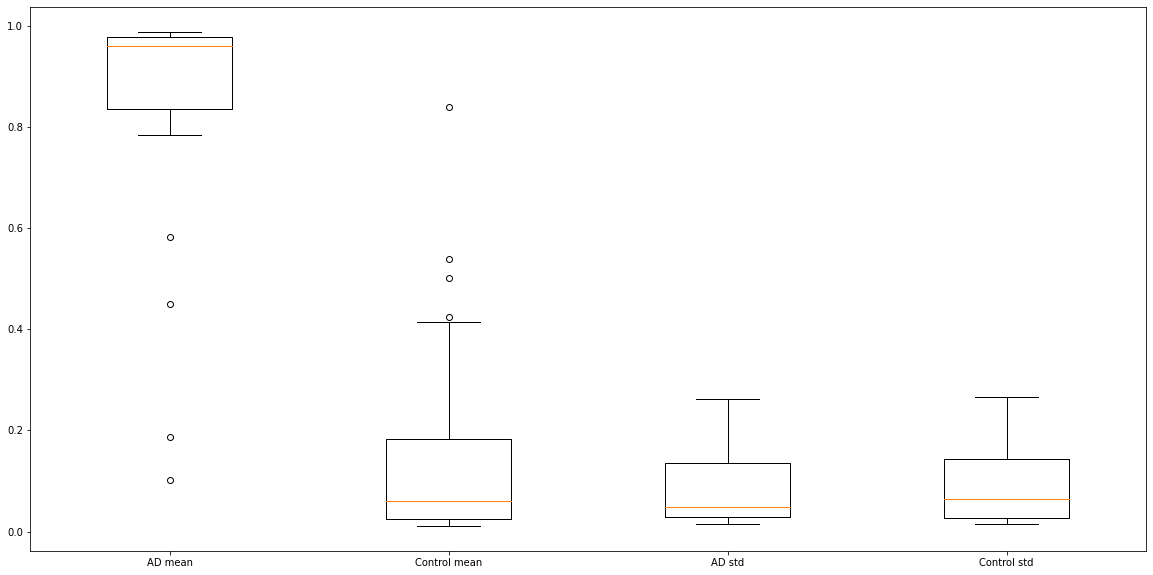

In [8]:
plt.subplots(figsize=(20, 10))
all_data = [joined_df[joined_df.diagnosis == 1]['mean'].values, 
            joined_df[joined_df.diagnosis == 0]['mean'].values,
            ##
            joined_df[joined_df.diagnosis == 1]['std'].values,
            joined_df[joined_df.diagnosis == 0]['std'].values,]


_ = plt.boxplot(all_data, labels=['AD mean', 'Control mean',
                                  'AD std', 'Control std'])
plt.show()
plt.close()

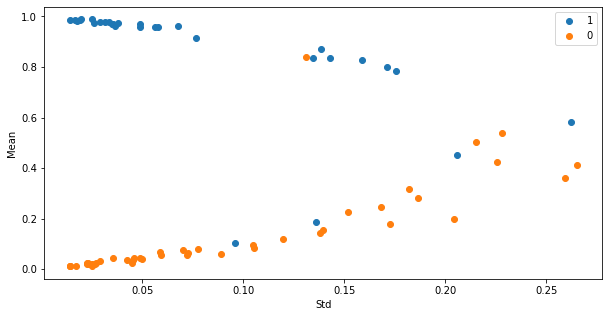

In [5]:
plt.subplots(figsize=(10, 5))

for diagnosis in [1, 0]:
    tmp_df = joined_df[joined_df.diagnosis == diagnosis]

    plt.scatter(tmp_df['std'], tmp_df['mean'], label=diagnosis)

plt.legend()
plt.xlabel('Std')
plt.ylabel('Mean')
plt.show()
plt.close()

## ADNI train data

python inference.py --dataset_location data/adni_train_scaled_corrected.csv --dataset_id adni_train

python inference.py --dataset_location data/adni_train_scaled_corrected.csv --dataset_id adni_train --do_single_pass

## MC-Drop vs single-pass: AUC Roc Curve

In [6]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


In [7]:
single_pass = pd.read_csv('latest_output_adni_1.csv', index_col=0)
single_pass = single_pass.join(adni_diag, how='inner')
#single_pass = single_pass[(single_pass.diagnosis == 'AD') | (single_pass.diagnosis == 'Control')]
single_pass

,mean,std,diagnosis
adni_id,,,
sub-002-S-1018,0.447093,NaN,1
sub-002-S-4213,0.005362,NaN,0
sub-003-S-0981,0.009145,NaN,0
sub-003-S-1059,0.957235,NaN,1
sub-003-S-4373,0.991371,NaN,1
...,...,...,...
sub-130-S-4641,0.121516,NaN,1
sub-130-S-4971,0.859160,NaN,1
sub-130-S-4990,0.988055,NaN,1


In [29]:
def plot_all_roc_curves(mcdrop_df, singlpass_df):
    def plot_roc_stuff(tmp_df, label, color):
        preds = tmp_df['mean']
        fpr, tpr, thresholds = metrics.roc_curve(tmp_df['diagnosis'], preds)
        roc_auc = metrics.auc(fpr, tpr)

        # Youden’s J statistic
        J = tpr - fpr
        ix = np.argmax(J)
        best_thresh = thresholds[ix]
        print(f'Best treshold for {label}: {best_thresh}')

        plt.plot(fpr, tpr, 'b', label = f'AUC {label} = %0.2f' % roc_auc, color=color)
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best {label}')

    plt.subplots(figsize=(20, 10))
    plt.title('Receiver Operating Characteristic')
    plot_roc_stuff(mcdrop_df, 'MC-Drop', 'orange')
    plot_roc_stuff(singlpass_df, 'Single Pass', 'green')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.close()

Best treshold for MC-Drop: 0.5821690559387207
Best treshold for Single Pass: 0.5884669423103333


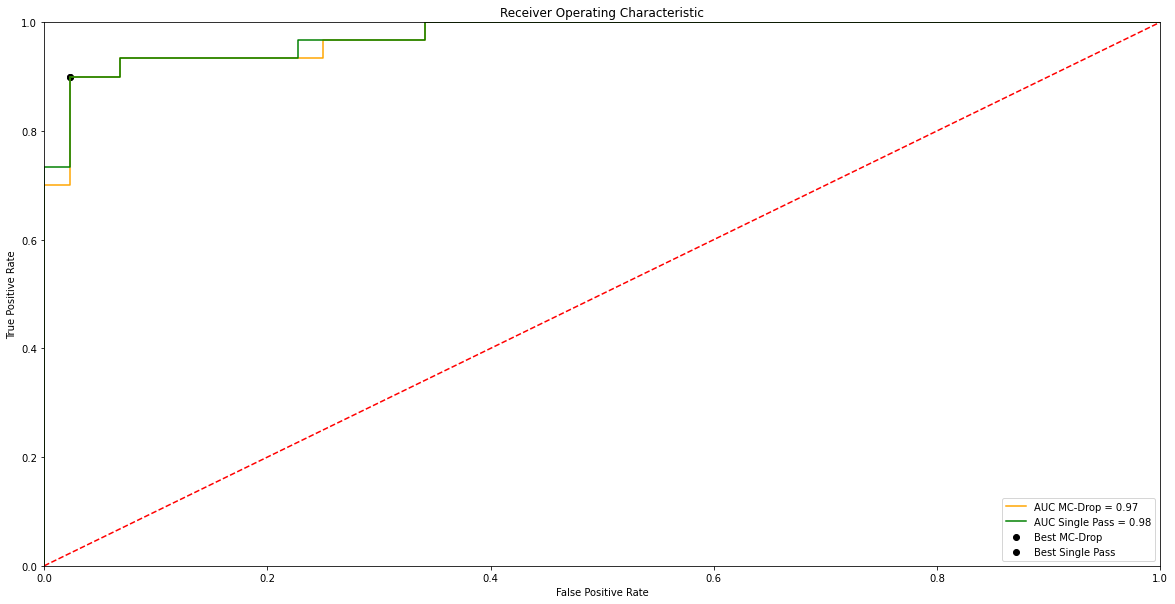

In [30]:
plot_all_roc_curves(joined_df, single_pass)

Best treshold for MC-Drop: 0.5821690559387207
Best treshold for Single Pass: 0.35471439361572266


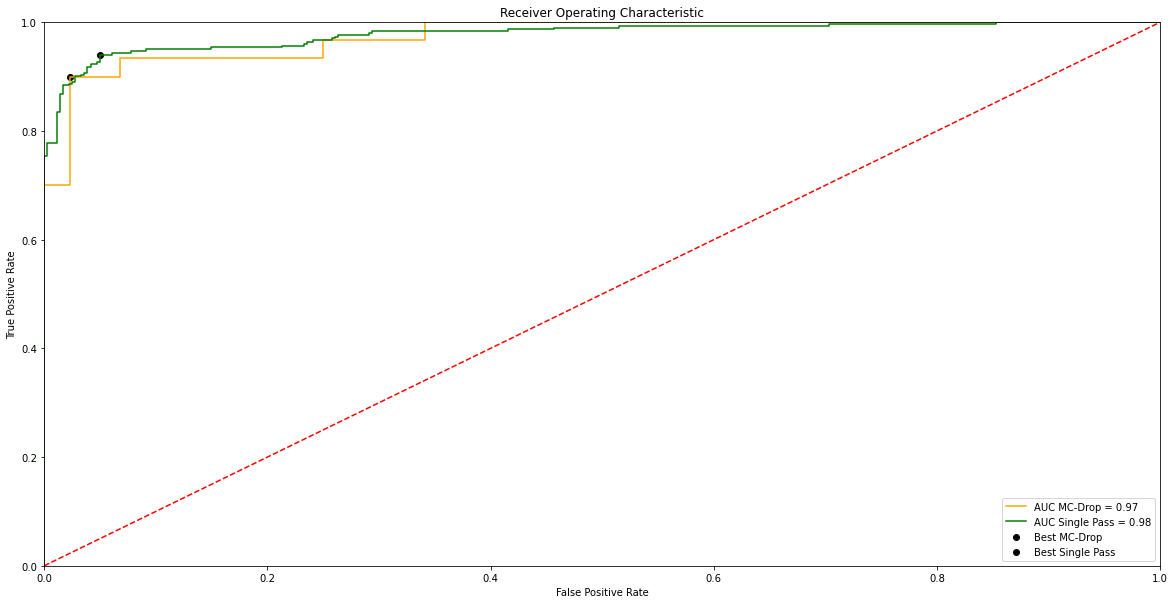

In [31]:
adni_train_diag = pd.read_csv('../data/adni_train_scaled_corrected.csv', index_col=0)['diagnosis']
res_train_df = pd.read_csv('latest_output_adni_train_50.csv', index_col=0)
joined_train_df = res_df.join(adni_diag, how='inner')



single_train_pass = pd.read_csv('latest_output_adni_train_1.csv', index_col=0)
single_train_pass = single_train_pass.join(adni_train_diag, how='inner')

plot_all_roc_curves(joined_train_df, single_train_pass)

In [40]:
def plot_all_pr_curves(mcdrop_df, singlpass_df):
    def plot_pr_stuff(tmp_df, label, color):
        preds = tmp_df['mean']
        #fpr, tpr, thresholds = metrics.roc_curve(tmp_df['diagnosis'], preds)
        #roc_auc = metrics.auc(fpr, tpr)
        precision, recall, thresholds = metrics.precision_recall_curve(tmp_df['diagnosis'], preds)

        # convert to f score
        fscore = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        print(f'Best Threshold for {label}=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
        # Youden’s J statistic
        #J = tpr - fpr
        #ix = np.argmax(J)
        #best_thresh = thresholds[ix]
        #print(f'Best treshold for {label}: {best_thresh}')

        #plt.plot(fpr, tpr, 'b', label = f'AUC {label} = %0.2f' % roc_auc, color=color)
        plt.scatter(recall[ix], precision[ix], marker='o', color='black', label=f'Best {label}')
        #plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best {label}')
        plt.plot(recall, precision, marker='.', label = f'{label}', color=color)

    plt.subplots(figsize=(20, 10))
    plt.title('Receiver Operating Characteristic')
    plot_pr_stuff(mcdrop_df, 'MC-Drop', 'orange')
    plot_pr_stuff(singlpass_df, 'Single Pass', 'green')
    plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.close()

Best Threshold for MC-Drop=0.582169, F-Score=0.931
Best Threshold for Single Pass=0.588467, F-Score=0.931


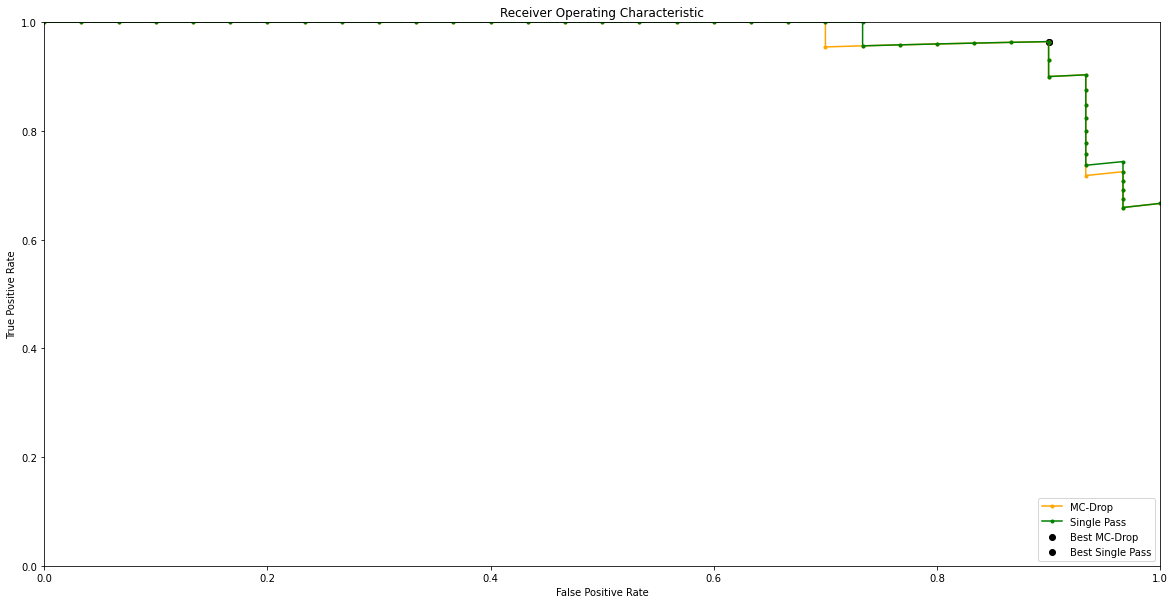

In [41]:
plot_all_pr_curves(joined_df, single_pass)

Best Threshold for MC-Drop=0.582169, F-Score=0.931
Best Threshold for Single Pass=0.354714, F-Score=0.940


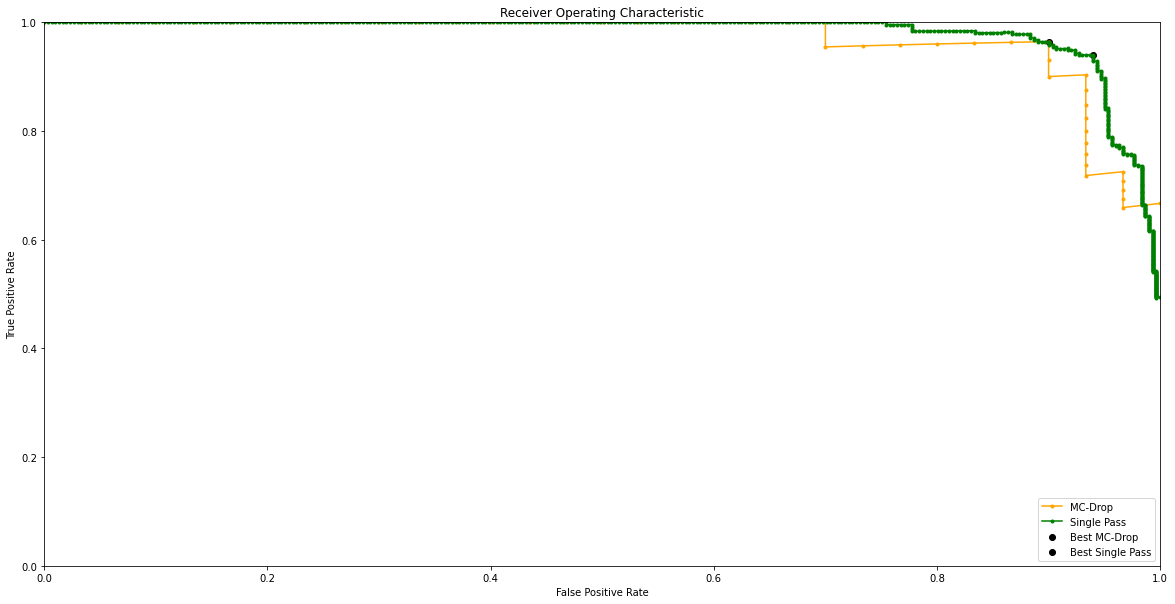

In [42]:
plot_all_pr_curves(joined_train_df, single_train_pass)

## MC-Drop (uncertainty) vs MC-Drop (delta) vs single-pass (delta)

In [12]:
def populate_arrs_for_df(df, accs_arr, sens_arr, spes_arr, people_arr, ppvs_arr, npvs_arr):
    probs = tmp_df['mean'].values
    probs[probs < 0.5] = 0
    probs[probs > 0.5] = 1
    
    tn, fp, fn, tp = metrics.confusion_matrix(tmp_df['diagnosis'].values, probs).ravel()
    specificity = tn / (tn + fp)
    sensitivty = tp / (tp + fn)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    
    accs_arr.append(metrics.accuracy_score(tmp_df['diagnosis'].values, probs))
    sens_arr.append(sensitivty)
    spes_arr.append(specificity)
    people_arr.append(tmp_df.shape[0])
    ppvs_arr.append(ppv)
    npvs_arr.append(npv)
    

### MC-Drop with uncertainty thresholding

In [13]:
accs = []
sens = []
spes = []
people = []
ppvs = [] # precision / positive predictive value
npvs = [] # negative predictive value
for std_val in np.arange(0.015, 0.36, 0.001):
    
    tmp_df = joined_df.loc[joined_df['std'] < std_val, :]
    populate_arrs_for_df(tmp_df, accs, sens, spes, people, ppvs, npvs)

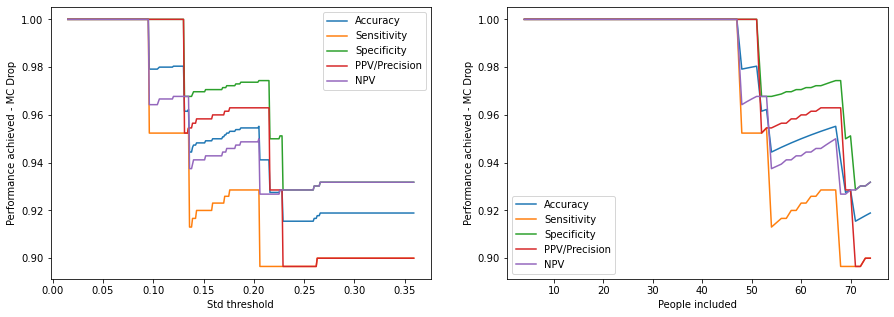

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(np.arange(0.015, 0.36, 0.001), accs, label='Accuracy')
axs[0].plot(np.arange(0.015, 0.36, 0.001), sens, label='Sensitivity')
axs[0].plot(np.arange(0.015, 0.36, 0.001), spes, label='Specificity')
axs[0].plot(np.arange(0.015, 0.36, 0.001), ppvs, label='PPV/Precision')
axs[0].plot(np.arange(0.015, 0.36, 0.001), npvs, label='NPV')
axs[0].set_xlabel('Std threshold')
axs[0].set_ylabel('Performance achieved - MC Drop')
axs[0].legend()

axs[1].plot(people, accs, label='Accuracy')
axs[1].plot(people, sens, label='Sensitivity')
axs[1].plot(people, spes, label='Specificity')
axs[1].plot(people, ppvs, label='PPV/Precision')
axs[1].plot(people, npvs, label='NPV')
axs[1].set_xlabel('People included')
axs[1].set_ylabel('Performance achieved - MC Drop')
axs[1].legend()

plt.show()

### MC-Drop vs Single-pass with probability-delta thresholding

In [17]:
accs_delta_mc, accs_delta_1 = [], []
sens_delta_mc, sens_delta_1 = [], []
spes_delta_mc, spes_delta_1 = [], []
people_delta_mc, people_delta_1 = [], []
ppvs_delta_mc, ppvs_delta_1 = [], []
npvs_delta_mc, npvs_delta_1 = [], []

for delta_val in np.arange(0.012, 0.51, 0.001):

    tmp_df = joined_df.loc[(joined_df['mean'] < delta_val) | (joined_df['mean'] > 1- delta_val), :]
    populate_arrs_for_df(tmp_df, accs_delta_mc, sens_delta_mc, spes_delta_mc, people_delta_mc, ppvs_delta_mc, npvs_delta_mc)
    
    tmp_df = single_pass.loc[(single_pass['mean'] < delta_val) | (single_pass['mean'] > 1- delta_val), :]
    populate_arrs_for_df(tmp_df, accs_delta_1, sens_delta_1, spes_delta_1, people_delta_1, ppvs_delta_1, npvs_delta_1)

In [20]:
def plot_across_metrics(x_vals_mc, x_vals_1, x_label):
    fig, axs = plt.subplots(1, 5, figsize=(20,5))

    axs[0].plot(x_vals_mc, accs_delta_mc, label='Accuracy - MC Drop')
    axs[0].plot(x_vals_1, accs_delta_1, label='Accuracy - Single')

    axs[1].plot(x_vals_mc, sens_delta_mc, label='Sensitivity - MC Drop')
    axs[1].plot(x_vals_1, sens_delta_1, label='Sensitivity - Single')

    axs[2].plot(x_vals_mc, spes_delta_mc, label='Specificity - MC Drop')
    axs[2].plot(x_vals_1, spes_delta_1, label='Specificity - Single')
    
    axs[3].plot(x_vals_mc, ppvs_delta_mc, label='PPV/Precision - MC Drop')
    axs[3].plot(x_vals_1, ppvs_delta_1, label='PPV/Precision - Single')
    
    axs[4].plot(x_vals_mc, npvs_delta_mc, label='NPV - MC Drop')
    axs[4].plot(x_vals_1, npvs_delta_1, label='NPV - Single')

    for ax in axs:
        ax.set_xlabel(x_label)
        ax.set_ylabel('Performance achieved')
        ax.legend()
    
    plt.show()

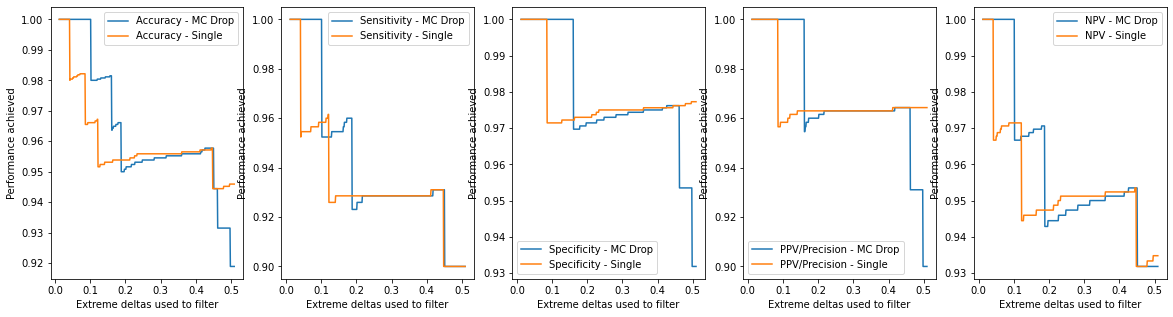

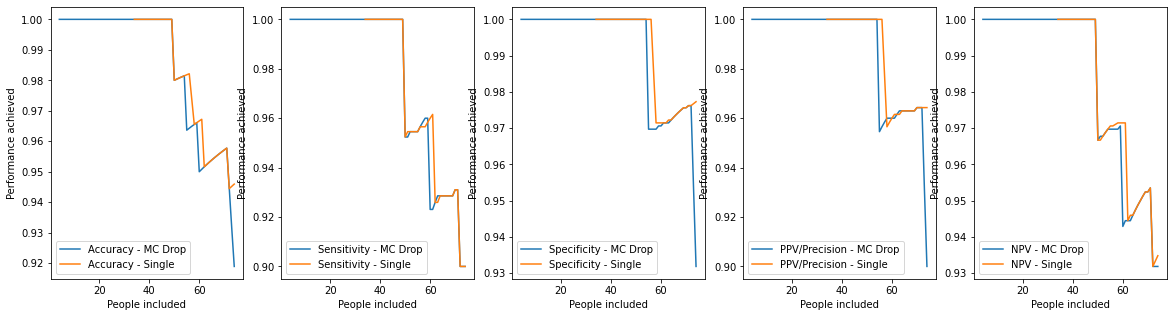

In [21]:
plot_across_metrics(np.arange(0.012, 0.51, 0.001), np.arange(0.012, 0.51, 0.001), 'Extreme deltas used to filter')
plot_across_metrics(people_delta_mc, people_delta_1, 'People included')


## Comparing the three approaches across people included

In [23]:
def plot_people_vs_var(vals_mc, vals_1, vals_uncert, metric_name):
    plt.subplots(figsize=(20,5))
    plt.plot(people_delta_mc, vals_mc, 'o-', label='Considering delta - MC Drop')
    plt.plot(people_delta_1, vals_1, '|-', label='Considering delta - Single')
    plt.plot(people, vals_uncert, 'x-', label='Considering uncertainty')
    plt.xlabel('People included')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

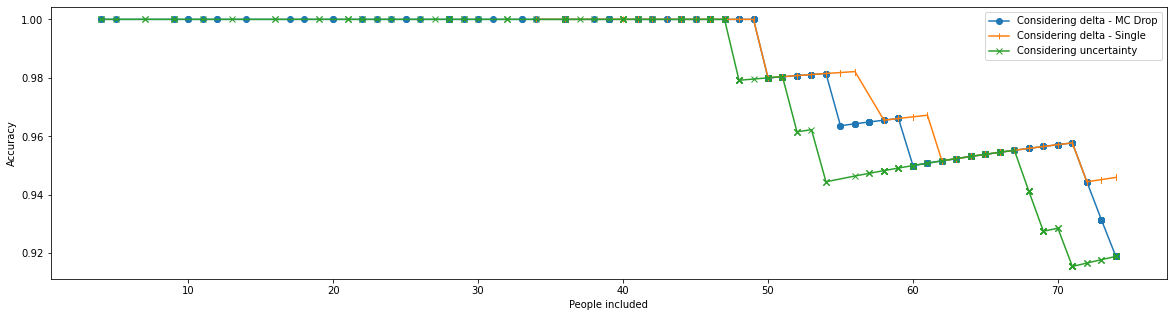

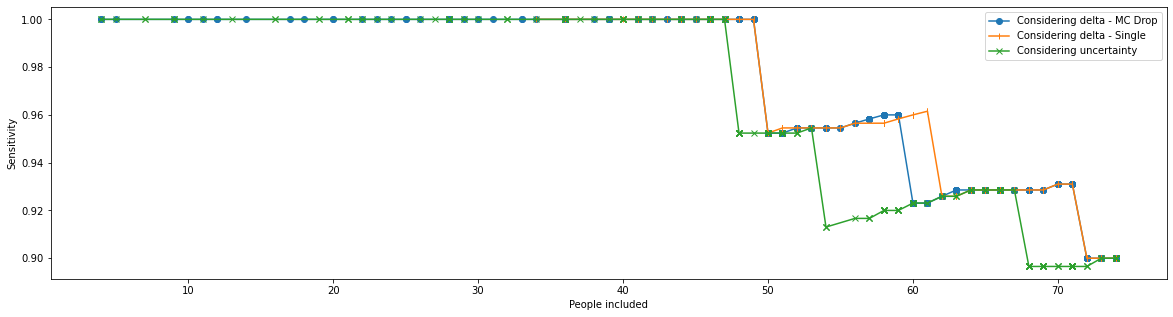

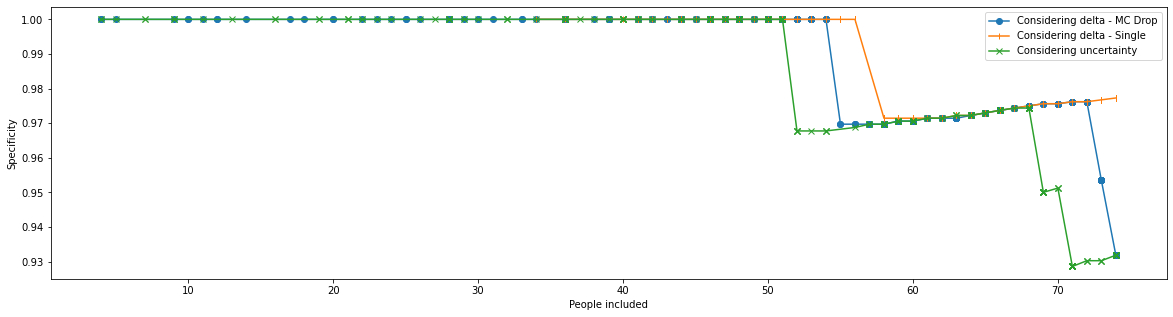

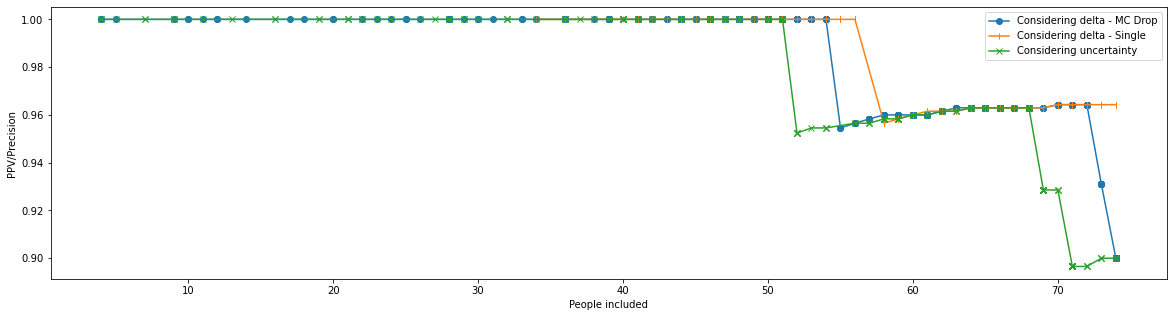

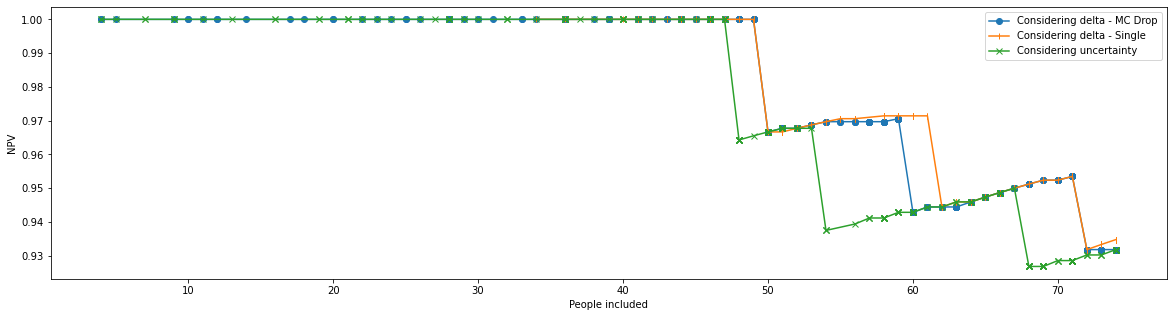

In [28]:
plot_people_vs_var(accs_delta_mc, accs_delta_1, accs, 'Accuracy')
plot_people_vs_var(sens_delta_mc, sens_delta_1, sens, 'Sensitivity')
plot_people_vs_var(spes_delta_mc, spes_delta_1, spes, 'Specificity')
plot_people_vs_var(ppvs_delta_mc, ppvs_delta_1, ppvs, 'PPV/Precision')
plot_people_vs_var(npvs_delta_mc, npvs_delta_1, npvs, 'NPV')